In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




df = pd.read_csv('data/real_estate_regression.csv')

df['date_created'] = pd.to_datetime(df['date_created'])
df['date_created_first'] = pd.to_datetime(df['date_created_first'])
df['pushed_up_at'] = pd.to_datetime(df['pushed_up_at'], errors='coerce', utc=True)


df['price_per_m2'] = df['price']/df['area_m2']


df.drop_duplicates(subset=['id'], inplace=True)

# we only have SELL type data
df.drop(columns=['transaction_type', 'id', 'date_created', 'date_created_first', 'pushed_up_at'], inplace=True)

df.rename(columns={'location.district': 'district', 'location.latitude': 'latitude',
       'location.longitude': 'longitude'}, inplace=True)

df['building_year'] = np.select([df['building_year']<1800, df['building_year']>2028], [np.nan, np.nan], default=df['building_year'])
df['building_age'] = pd.Timestamp.now().year - df['building_year']


floor_mapping = {
    'CELLAR': -1,
    'GROUND': 0,
    'FIRST': 1,
    'SECOND': 2,
    'THIRD': 3,
    'FOURTH': 4,
    'FIFTH': 5,
    'SIXTH': 6,
    'SEVENTH': 7,
    'EIGHTH': 8,
    'NINTH': 9,
    'TENTH': 10,
    'ABOVE_TENTH': 11,
    'GARRET': 12 
}


df['floor_number'] = df['floor_number'].map(floor_mapping)

# remove outliers, where price=1, etc
df = df[df['estate']=="FLAT"].reset_index(drop=True)

cond1 = df['price_per_m2']>1000
cond2 = df['area_m2']>=10 # 
# remove outliers
cond3 = df['area_m2'] < df['area_m2'].mean() + df['area_m2'].std()*3
cond4 = df['price'] < df['price'].mean() + df['price'].std()*3
cond5 = df['building_floors_num']< df['building_floors_num'].mean() + df['building_floors_num'].std()*3

df = df[cond1&cond2&cond3&cond4&cond5].reset_index(drop=True)




In [479]:
ENABLE_HYPERPARAM_TUNING = True


# Exploratory

In [440]:
dtypes_df = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

print(dtypes_df)

numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if 'has_' not in col]
summary = df[numeric_cols].describe().T
summary['skew'] = df[numeric_cols].skew()
summary['kurtosis'] = df[numeric_cols].kurtosis()

display(summary)

                     Data Type  Missing Values  Missing Percentage
estate                  object               0                0.00
district                object             515                1.37
latitude               float64               0                0.00
longitude              float64               0                0.00
is_private_owner          bool               0                0.00
advertiser_type         object            1682                4.47
area_m2                float64               0                0.00
rooms_number            object               0                0.00
floor_number           float64             133                0.35
windows_type            object           15545               41.32
heating                 object            9106               24.20
building_year          float64            2800                7.44
building_type           object            6707               17.83
building_floors_num    float64               0                

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
latitude,37625.0,5.223155e+01,0.047808,52.104636,52.197298,52.230600,5.225968e+01,5.236440e+01,0.313701,-0.228875
longitude,37625.0,2.100581e+01,0.067420,20.856116,20.956502,21.006610,2.105188e+01,2.125244e+01,0.287406,0.222374
area_m2,37625.0,5.594108e+01,24.429308,10.000000,39.500000,50.810000,6.518000e+01,6.800000e+02,2.295290,18.156641
floor_number,37492.0,3.080444e+00,2.706394,-1.000000,1.000000,2.000000,4.000000e+00,1.200000e+01,1.155918,0.860101
building_year,34825.0,1.995802e+03,29.549762,1810.000000,1972.000000,2007.000000,2.023000e+03,2.027000e+03,-0.907889,0.292814
building_floors_num,37625.0,6.344505e+00,3.862471,1.000000,4.000000,5.000000,8.000000e+00,5.400000e+01,1.996039,8.890249
price,37625.0,1.023299e+06,526543.444923,11111.000000,690000.000000,864000.000000,1.187952e+06,3.650000e+06,1.990897,4.641596
price_per_m2,37625.0,1.850336e+04,5053.363600,1111.100000,15000.000000,17504.051864,2.090000e+04,6.666667e+04,1.521062,4.634982
building_age,34825.0,2.919805e+01,29.549762,-2.000000,2.000000,18.000000,5.300000e+01,2.150000e+02,0.907889,0.292814


In [503]:
distrincts = df['district'].value_counts()
top_districts = distrincts[distrincts>100][:15].index.values


array(['mokotow', 'wola', 'bialoleka', 'srodmiescie', 'bemowo', 'ursus',
       'praga-poludnie', 'bielany', 'ursynow', 'wilanow', 'praga-polnoc',
       'ochota', 'wlochy', 'targowek', 'praga'], dtype=object)

/var/folders/3r/_0ptqbr15_970chzxcs_tb040000gn/T/ipykernel_50285/3348544734.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data,


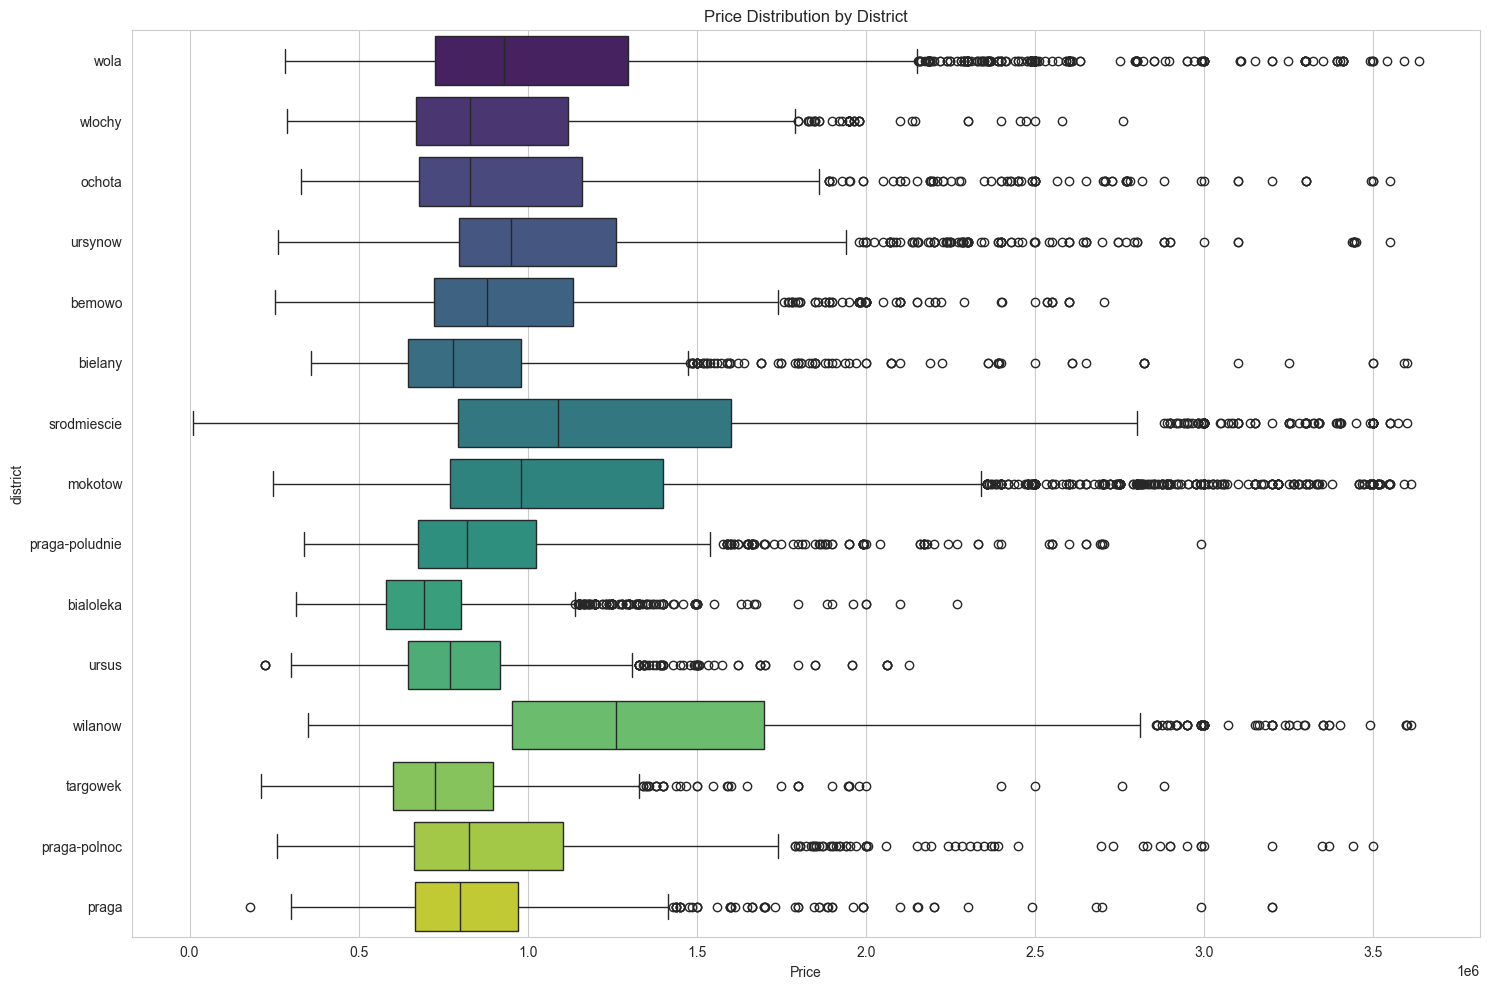

In [509]:
plot_data = df[df['district'].isin(top_districts)].copy()

# Set up the plotting style
sns.set_style("whitegrid")
#plt.style.use('seaborn')

# Create a figure with subplots
fig = plt.figure(figsize=(15, 10))


sns.boxplot(data=plot_data, 
            x='price', 
            y='district',
            orient='h',
            palette='viridis')
plt.title('Price Distribution by District')
plt.xlabel('Price')

# Adjust layout
plt.tight_layout()


<Axes: >

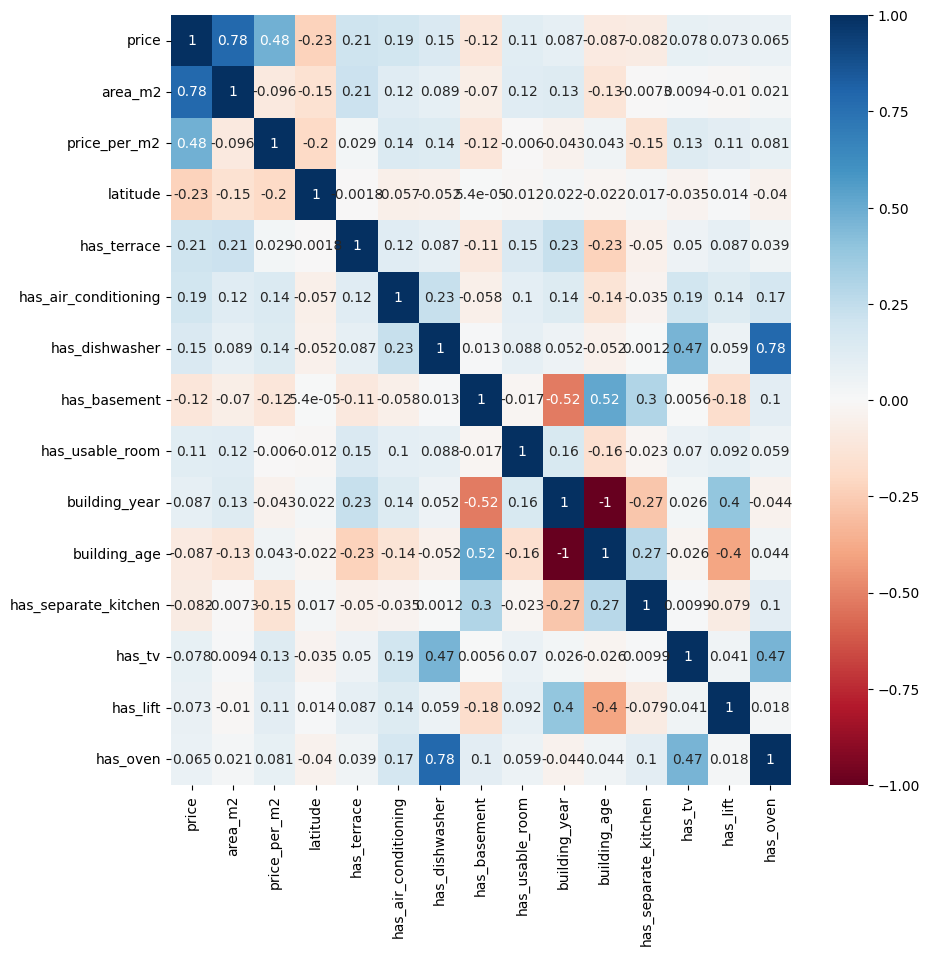

In [448]:
numeric_cols = df.select_dtypes(include=np.number).columns



plt.figure(figsize=(10, 10))
top_features = df[numeric_cols].corr()['price'].sort_values(ascending=False).abs().nlargest(15)  
top_corr = df[top_features.index].corr()

sns.heatmap(top_corr, 
            annot=True, 
            cmap='RdBu', 
            vmin=-1, 
            vmax=1, 
            center=0)

In [449]:
df.groupby(['estate', 'has_balcony']).agg({'price': 'describe'})

price                                                   \
                      count          mean            std       min       25%   
estate has_balcony                                                             
FLAT   0            14395.0  1.014684e+06  552192.926234  180000.0  653972.5   
       1            23230.0  1.028637e+06  509941.333239   11111.0  700000.0   

                                                    
                         50%        75%        max  
estate has_balcony                                  
FLAT   0            849000.0  1195000.0  3650000.0  
       1            875000.0  1179000.0  3630000.0

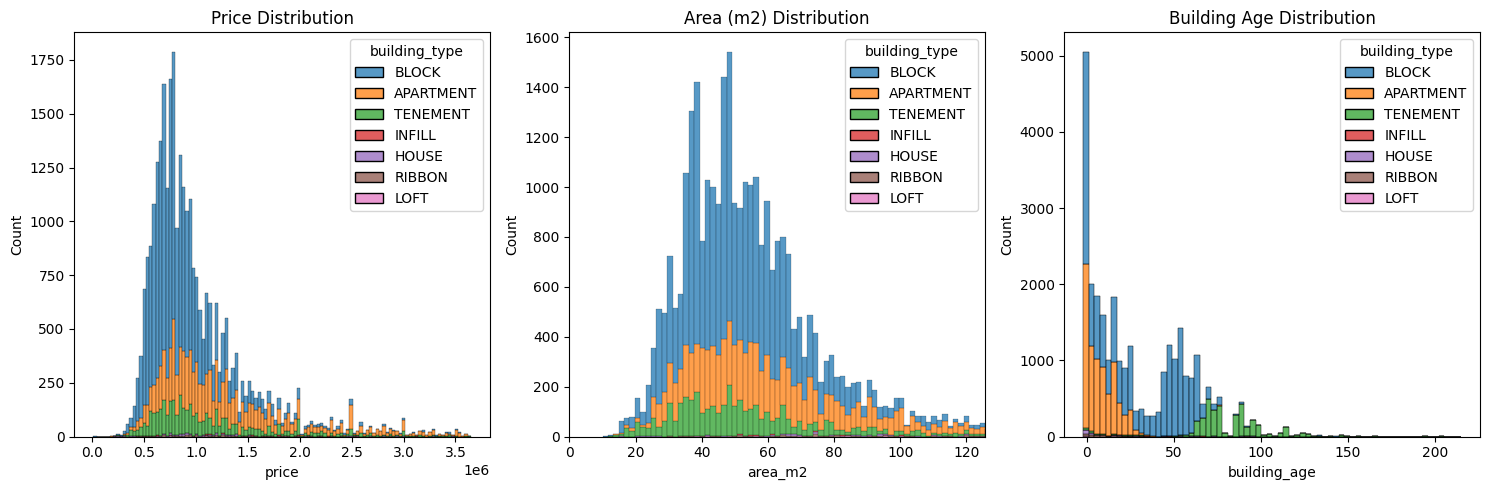

In [450]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.histplot(data=df, x='price', hue='building_type', multiple="stack")
plt.title('Price Distribution')

plt.subplot(132)
sns.histplot(data=df, x='area_m2', hue='building_type', multiple="stack")
plt.xlim(0, df['area_m2'].quantile(0.98))
plt.title('Area (m2) Distribution')

plt.subplot(133)
sns.histplot(data=df, x='building_age', hue='building_type', multiple="stack")
plt.title('Building Age Distribution')

plt.tight_layout()
plt.show()

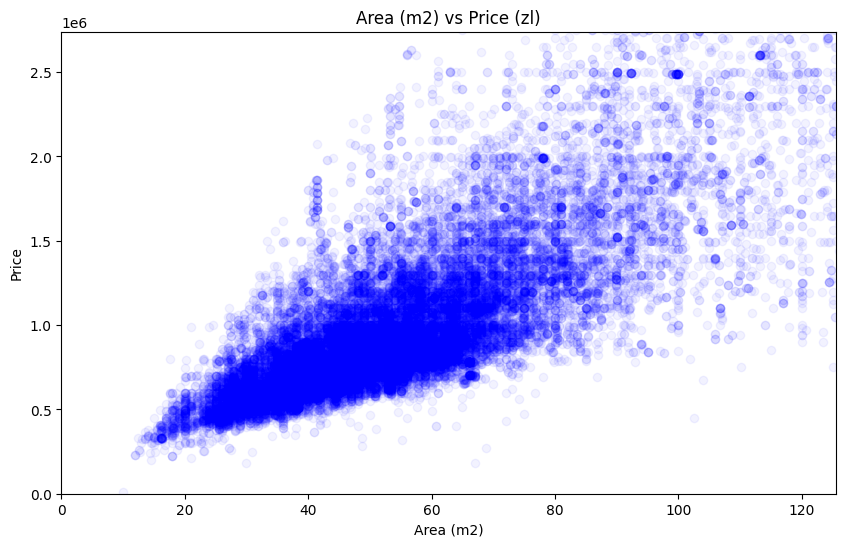

In [432]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

plt.scatter(df['area_m2'], df['price'], color="blue", alpha=0.05)

plt.title('Area (m2) vs Price (zl)')
plt.xlabel('Area (m2)')
plt.ylabel('Price')
plt.xlim(0, df['area_m2'].quantile(0.98))
plt.ylim(0, df['price'].quantile(0.98))
#plt.legend()

plt.show()

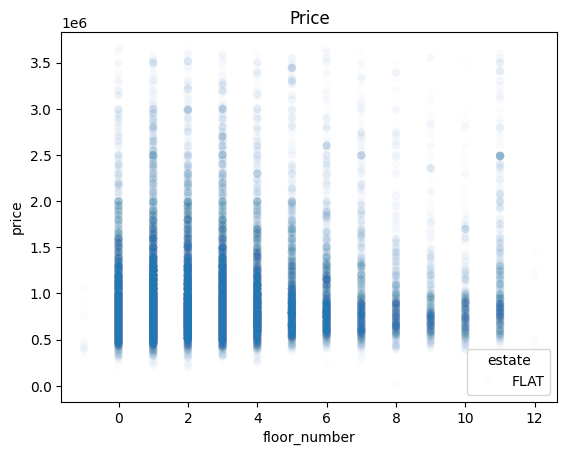

In [453]:
sns.scatterplot(data=df, x='floor_number', y='price', hue='estate', alpha=0.01)
plt.title(f'Price')
#plt.tight_layout()
plt.show()

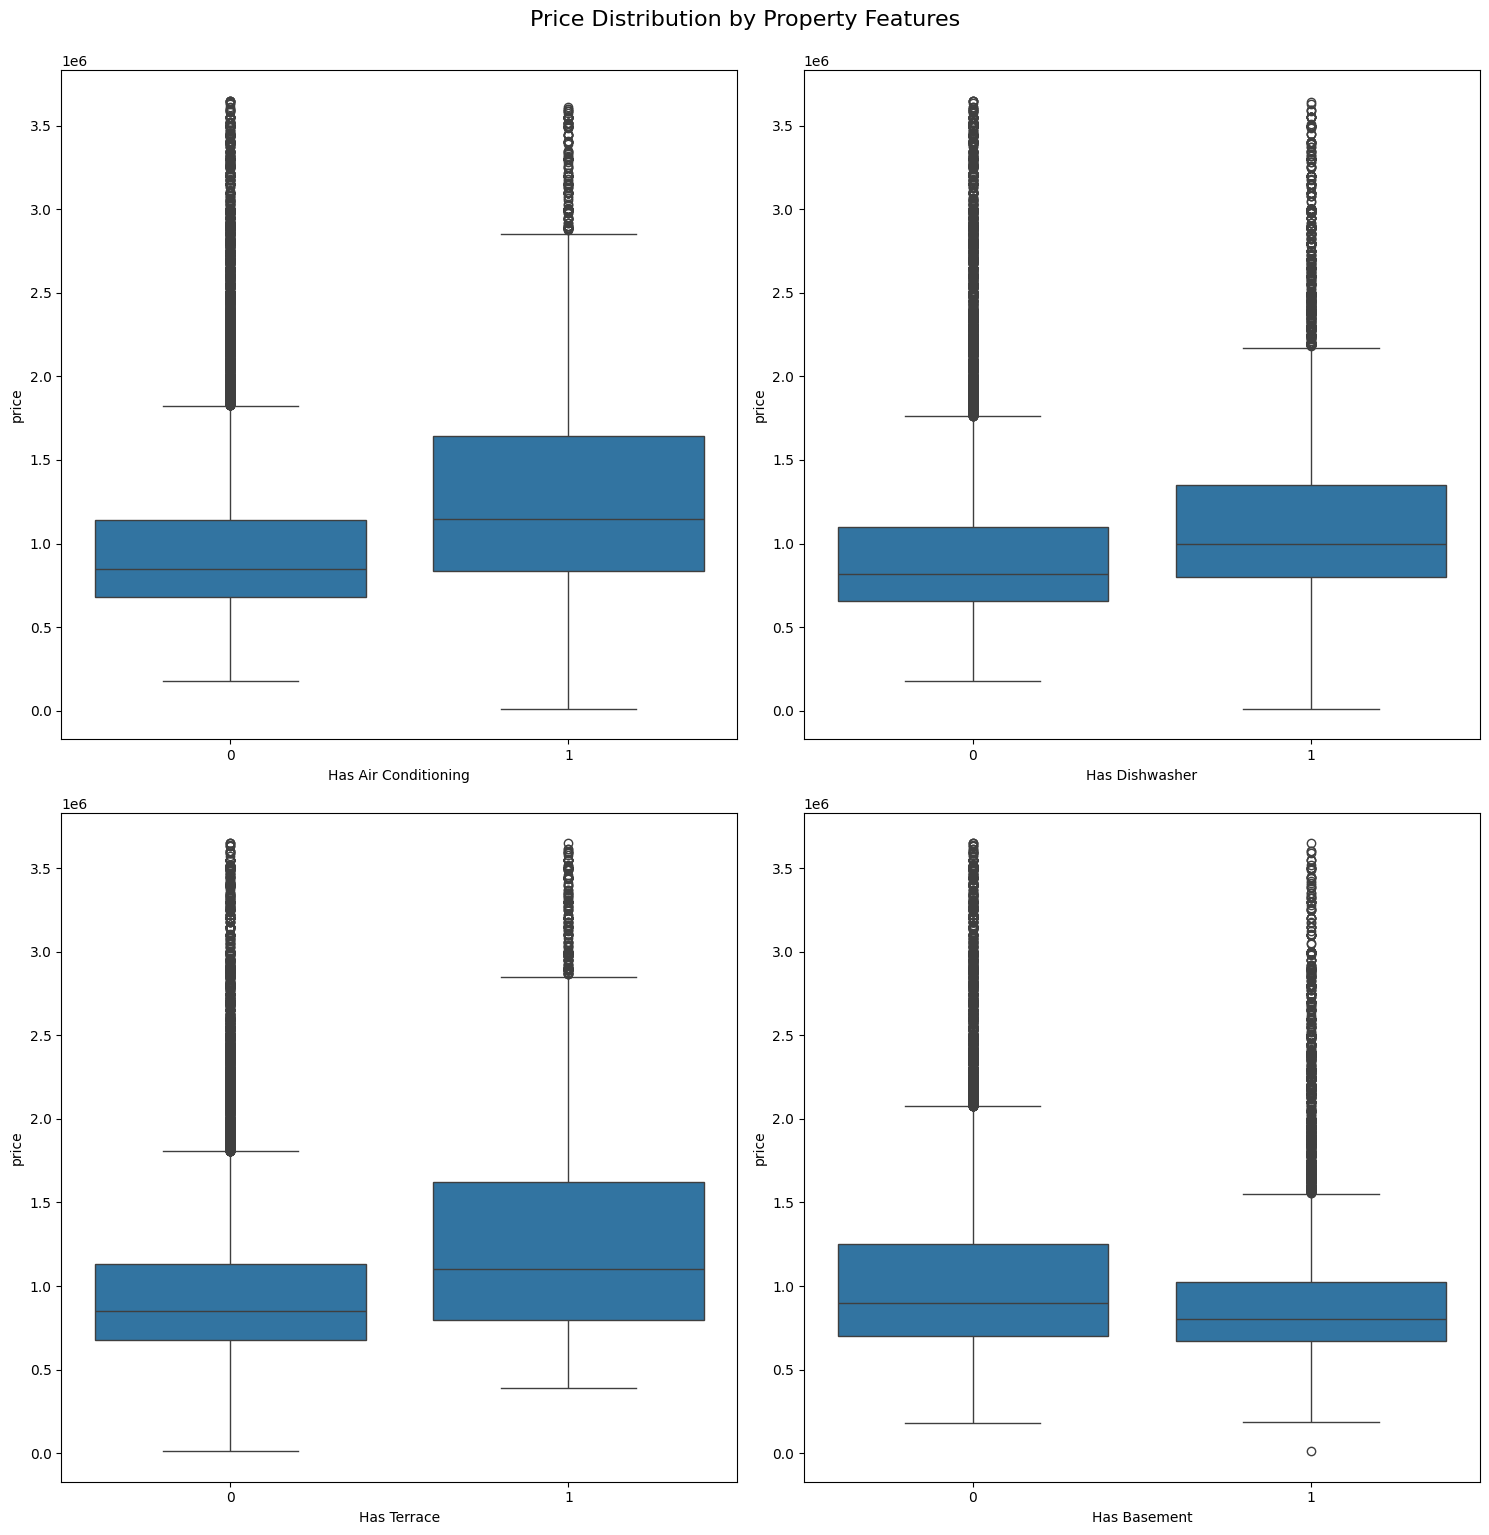

In [457]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Create boxplots for each feature
# Top left
sns.boxplot(data=df, x='has_air_conditioning', y='price', ax=axes[0,0])
#axes[0,0].set_title('Price Distribution by Air Conditioning')
axes[0,0].set_xlabel('Has Air Conditioning')

# Top right
sns.boxplot(data=df, x='has_dishwasher', y='price', ax=axes[0,1])
#axes[0,1].set_title('Dishwasher Boxplot')
axes[0,1].set_xlabel('Has Dishwasher')

# Bottom left
sns.boxplot(data=df, x='has_terrace', y='price', ax=axes[1,0])
#axes[1,0].set_title('Terrace Boxplot')
axes[1,0].set_xlabel('Has Terrace')

# Bottom right
sns.boxplot(data=df, x='has_basement', y='price', ax=axes[1,1])
#axes[1,1].set_title('Basement Boxplot')
axes[1,1].set_xlabel('Has Basement')

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a main title to the figure
fig.suptitle('Price Distribution by Property Features', y=1.02, fontsize=16)

# Show the plot
plt.show()

In [357]:
df.columns

Index(['estate', 'district', 'latitude', 'longitude', 'is_private_owner',
       'advertiser_type', 'area_m2', 'rooms_number', 'floor_number',
       'windows_type', 'heating', 'building_year', 'building_type',
       'building_floors_num', 'floors_num', 'construction_status',
       'building_material', 'building_ownership', 'has_lift', 'has_internet',
       'has_furniture', 'has_air_conditioning', 'has_tv', 'has_oven',
       'has_stove', 'has_dishwasher', 'has_fridge', 'has_washing_machine',
       'has_separate_kitchen', 'has_garage', 'has_usable_room', 'has_terrace',
       'has_balcony', 'has_attic', 'has_basement', 'has_garden', 'has_pool',
       'price', 'price_per_m2', 'building_age'],
      dtype='object')

In [358]:
df

,estate,district,latitude,longitude,is_private_owner,advertiser_type,area_m2,rooms_number,floor_number,windows_type,...,has_usable_room,has_terrace,has_balcony,has_attic,has_basement,has_garden,has_pool,price,price_per_m2,building_age
0,FLAT,wola,52.231839,20.937315,True,PRIVATE,37.00,2,FIRST,PLASTIC,...,0,0,1,0,1,0,0,610000.0,16486.486486,55.0
1,FLAT,gorny-mokotow,52.181213,21.026067,True,PRIVATE,54.51,2,FOURTH,PLASTIC,...,0,0,1,0,0,0,0,1080000.0,19812.878371,16.0
2,FLAT,piaski,52.268537,20.949353,True,PRIVATE,47.00,3,SECOND,PLASTIC,...,0,0,1,0,1,0,0,780000.0,16595.744681,52.0
3,FLAT,mokotow,52.205586,21.032873,False,AGENCY,240.00,7,SECOND,NaN,...,0,1,1,0,0,0,0,4300000.0,17916.666667,4.0
4,HOUSE,ochota,52.209970,20.967270,False,AGENCY,290.00,6,NaN,PLASTIC,...,0,0,0,0,0,0,0,3300000.0,11379.310345,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43246,FLAT,praga-poludnie,52.245768,21.104622,False,AGENCY,65.00,3,FIFTH,NaN,...,0,0,1,0,1,0,0,960000.0,14769.230769,28.0
43247,FLAT,mokotow,52.163980,20.992850,False,AGENCY,43.01,2,THIRD,NaN,...,1,0,1,0,0,0,0,980000.0,22785.398744,9.0
43248,FLAT,nowodwory,52.321090,20.938550,False,AGENCY,38.50,2,FIRST,NaN,...,0,1,0,0,0,0,0,569000.0,14779.220779,25.0
43249,FLAT,praga,52.228600,21.065010,False,AGENCY,57.00,3,THIRD,NaN,...,0,0,1,0,0,0,0,1019000.0,17877.192982,1.0


In [359]:
names_categorical = df.select_dtypes(np.object_).columns

list_name_variable = []
list_levels = []
nan_count = []

for i in range(0,len(names_categorical)):

    name_variable_x =  names_categorical[i] 
    
    levels_x = df[names_categorical [i]].unique()
    
    list_name_variable.append(name_variable_x)
    list_levels.append(levels_x)
    nan_count.append(df[names_categorical [i]].isna().sum())
    
print("String variables and their levels")
d = {'name_variable': list_name_variable, 
     'levels' : list_levels,
     'n_levels': [len(level) for level in list_levels],
     'nan_count': nan_count}

variable_def = pd.DataFrame(data=d)
variable_def

String variables and their levels


,name_variable,levels,n_levels,nan_count
0,estate,"[FLAT, HOUSE]",2,0
1,district,"[wola, gorny-mokotow, piaski, mokotow, ochota,...",179,664
2,advertiser_type,"[PRIVATE, AGENCY, nan, DEVELOPER]",4,1819
3,rooms_number,"[2, 3, 7, 6, 1, 4, 5, 8, 9, MORE, 10, nan]",12,1
4,floor_number,"[FIRST, FOURTH, SECOND, nan, GROUND, FIFTH, TH...",15,4135
5,windows_type,"[PLASTIC, nan, ALUMINIUM, WOODEN, NOTANY]",5,17806
6,heating,"[URBAN, nan, OTHER, GAS, BOILER_ROOM, ELECTRIC...",7,12247
7,building_type,"[BLOCK, APARTMENT, nan, TENEMENT, DETACHED, RI...",11,7507
8,floors_num,"[nan, ONE_FLOOR, TWO_FLOORS, MORE, GROUND_FLOOR]",5,40150
9,construction_status,"[READY_TO_USE, TO_COMPLETION, nan, TO_RENOVATI...",6,7001


In [360]:

categorical_columns = df.select_dtypes(include=['object']).columns

print("We have " + str(len(categorical_columns)) + " columns of type object to encode")
print("Names of the columns that needs to be encoded: "+ "\n" + str(categorical_columns))
df.select_dtypes(include=['object']).head()

We have 12 columns of type object to encode
Names of the columns that needs to be encoded: 
Index(['estate', 'district', 'advertiser_type', 'rooms_number', 'floor_number',
       'windows_type', 'heating', 'building_type', 'floors_num',
       'construction_status', 'building_material', 'building_ownership'],
      dtype='object')


,estate,district,advertiser_type,rooms_number,floor_number,windows_type,heating,building_type,floors_num,construction_status,building_material,building_ownership
0,FLAT,wola,PRIVATE,2,FIRST,PLASTIC,URBAN,BLOCK,NaN,READY_TO_USE,CONCRETE_PLATE,NaN
1,FLAT,gorny-mokotow,PRIVATE,2,FOURTH,PLASTIC,URBAN,BLOCK,NaN,READY_TO_USE,REINFORCED_CONCRETE,FULL_OWNERSHIP
2,FLAT,piaski,PRIVATE,3,SECOND,PLASTIC,URBAN,BLOCK,NaN,READY_TO_USE,OTHER,LIMITED_OWNERSHIP
3,FLAT,mokotow,AGENCY,7,SECOND,NaN,NaN,APARTMENT,NaN,READY_TO_USE,[],NaN
4,HOUSE,ochota,AGENCY,6,NaN,PLASTIC,URBAN,NaN,ONE_FLOOR,READY_TO_USE,BREEZEBLOCK,NaN


In [361]:
import unicodedata
import re

def clean_text(text):
    """
    Clean and normalize text to handle special characters and symbols
    """
    if pd.isna(text):
        return text
    
    text = str(text).lower()   
   
    # Remove special characters
    text = ''.join(char for char in unicodedata.normalize('NFKD', text)
                  if unicodedata.category(char)[0] != 'P' or char in 'äöüß')
      
    # Replace special characters with underscore
    text = re.sub(r'[^a-z0-9]+', '_', text)
    
    # Remove multiple underscores
    text = re.sub(r'_+', '_', text)
    text = text.strip('_')
    
    return text




for i in range(0,len(categorical_columns)):
    column = categorical_columns[i]
    df[column] = df[column].apply(clean_text)
    df = pd.concat([df,pd.get_dummies(df[column],prefix=column)],axis=1).drop([column],axis=1)



In [362]:
df

,latitude,longitude,is_private_owner,area_m2,building_year,building_floors_num,has_lift,has_internet,has_furniture,has_air_conditioning,...,building_material_concreteplate,building_material_hydroton,building_material_other,building_material_reinforcedconcrete,building_material_silikat,building_material_wood,building_ownership_fullownership,building_ownership_limitedownership,building_ownership_share,building_ownership_usufruct
0,52.231839,20.937315,True,37.00,1970.0,10.0,1,1,0,0,...,True,False,False,False,False,False,False,False,False,False
1,52.181213,21.026067,True,54.51,2009.0,16.0,1,1,1,1,...,False,False,False,True,False,False,True,False,False,False
2,52.268537,20.949353,True,47.00,1973.0,4.0,0,1,0,0,...,False,False,True,False,False,False,False,True,False,False
3,52.205586,21.032873,False,240.00,2021.0,9.0,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,52.209970,20.967270,False,290.00,2000.0,NaN,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43246,52.245768,21.104622,False,65.00,1997.0,5.0,1,1,1,0,...,False,False,False,False,False,False,False,False,False,False
43247,52.163980,20.992850,False,43.01,2016.0,7.0,1,1,1,0,...,False,False,False,False,False,False,True,False,False,False
43248,52.321090,20.938550,False,38.50,2000.0,5.0,1,1,1,0,...,False,False,False,False,False,False,True,False,False,False
43249,52.228600,21.065010,False,57.00,2024.0,4.0,1,1,0,1,...,False,False,False,False,False,False,True,False,False,False


# Modeling

## Split train test data

In [363]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import datasets 
from sklearn.model_selection import train_test_split

from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import random

random.seed(45564556)


target_variable = "price"
df.drop(columns=['price_per_m2'], inplace=True)

feature_variables = df.columns.drop(target_variable)

df_train = df.sample(frac=0.8, random_state=1)
df_test = df.drop(df_train.index)

X_train = df_train[feature_variables]
X_test = df_test[feature_variables]
Y_train = df_train[target_variable]
Y_test = df_test[target_variable]



In [525]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error


def get_metrics(Y_test, Y_predict, which=None):
    mse = mean_squared_error(Y_test, Y_predict)
    rmse = root_mean_squared_error(Y_test, Y_predict)
    r2 = r2_score(Y_test, Y_predict)
    mape = mean_absolute_percentage_error(Y_test, Y_predict)

    if which:
        print(f'{which} metrics')
    metrics = pd.DataFrame({'mse' : [mse], 
                            'rmse':[rmse],
                            'r2':[r2],
                            'mape':[mape], 
                           })
    display(metrics)
    return 

## Decision Tree Regressor

In [558]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


param_dist = {
    'max_depth': randint(3, 200), 
    'min_samples_split': [5, 10, 20, 50, 100],  
    'min_samples_leaf': [5, 10, 20, 50], 
    'max_leaf_nodes': [10, 20, 30, 50, 100],
    'min_impurity_decrease': uniform(0, 0.1),
    'ccp_alpha': uniform(0, 0.05)
}


if ENABLE_HYPERPARAM_TUNING:

    random_search = RandomizedSearchCV(
        estimator=DecisionTreeRegressor(),
        param_distributions=param_dist,
        n_iter=100,
        scoring='neg_root_mean_squared_error', # neg_root_mean_squared_error, neg_mean_absolute_percentage_error
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    

    random_search.fit(X_train, Y_train)
    

    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)
    print(f"Best score: {random_search.best_score_:.4f}")
    

    best_model = DecisionTreeRegressor(**best_params)
    best_model.fit(X_train, Y_train)
    
else:
    print("Best Hyperparameters:", {})
    best_model = DecisionTreeRegressor()
    best_model.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'ccp_alpha': np.float64(0.00917022549267169), 'max_depth': 60, 'max_leaf_nodes': 100, 'min_impurity_decrease': np.float64(0.04319450186421158), 'min_samples_leaf': 5, 'min_samples_split': 20}
Best score: -654994.4092


In [559]:
Y_predict_train = best_model.predict(X_train)
Y_predict_test = best_model.predict(X_test)

get_metrics(Y_train, Y_predict_train, 'Train')
get_metrics(Y_test, Y_predict_test, 'Test')

Train metrics


,mse,rmse,r2,mape
0,3.062443e+11,553393.43851,0.801798,0.190251


Test metrics


,mse,rmse,r2,mape
0,3.798656e+11,616332.347873,0.755026,0.197068


## XGBoost

In [513]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.8),
    'n_estimators': randint(300, 700),
    'min_child_weight': randint(1, 7),
    'subsample': uniform(0.8, 0.2), 
    'colsample_bytree': uniform(0.8, 0.2)
}

if ENABLE_HYPERPARAM_TUNING:
    xbg_1 = RandomizedSearchCV(
        estimator=xgb.XGBRegressor(tree_method="hist"),
        param_distributions=param_dist,
        n_iter=25, 
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )
    
    xbg_1.fit(X_train, Y_train)

else:
    xbg_1 = xgb.XGBRegressor(tree_method="hist", 
                             colsample_bytree= np.float64(0.8500333727943479),
                             learning_rate= np.float64(0.2433278868201498),
                             max_depth=9,
                             min_child_weight= 6,
                             n_estimators= 414,
                             subsample= np.float64(0.9030188114585253)
                            )
xbg_1.best_params_

#xbg_1 = xgb.XGBRegressor(tree_method="hist", eval_metric=mean_absolute_error,)

# xbg_1.fit(X_train, Y_train)

#xbg_1.fit(X_train, Y_train, eval_set=[(X_train, Y_train)])

{'colsample_bytree': np.float64(0.8441917431863678),
 'learning_rate': np.float64(0.28187638172429963),
 'max_depth': 9,
 'min_child_weight': 2,
 'n_estimators': 120,
 'subsample': np.float64(0.993206057772797)}

In [532]:
Y_predict_train = xbg_1.predict(X_train)
Y_predict_test = xbg_1.predict(X_test)

get_metrics(Y_train, Y_predict_train, 'Train')
get_metrics(Y_test, Y_predict_test, 'Test')

Train metrics


,mse,rmse,r2,mape
0,1.642679e+10,128167.058563,0.989369,0.062925


Test metrics


,mse,rmse,r2,mape
0,1.539490e+11,392363.377567,0.900719,0.100936


## RandomForestRegressor

In [566]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np


param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['friedman_mse', 'squared_error', 'poisson'], #{'friedman_mse', 'squared_error', 'absolute_error', 'poisson'}
}


rf = RandomForestRegressor(random_state=42)


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=25, 
    cv=5,
    scoring='neg_mean_squared_error', # neg_mean_absolute_error, neg_root_mean_squared_error, neg_mean_absolute_percentage_error
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)


random_search.fit(X_train, Y_train)

print("Best parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")

# Get the best model
best_rf = random_search.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters found:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 171}

Best cross-validation score: -354375895601.041


In [567]:
Y_predict_train = best_rf.predict(X_train)
Y_predict_test = best_rf.predict(X_test)

get_metrics(Y_train, Y_predict_train, 'Train')
get_metrics(Y_test, Y_predict_test, 'Test')

Train metrics


,mse,rmse,r2,mape
0,2.306966e+11,480308.871687,0.850693,0.090269


Test metrics


,mse,rmse,r2,mape
0,2.711922e+11,520761.151118,0.825109,0.112595


[CV] END bootstrap=True, criterion=friedman_mse, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time= 1.1min
[CV] END bootstrap=False, criterion=poisson, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=3, n_estimators=241; total time=   1.1s
[CV] END bootstrap=False, criterion=poisson, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=3, n_estimators=241; total time=   1.1s
[CV] END bootstrap=False, criterion=friedman_mse, max_depth=1, max_features=log2, min_samples_leaf=6, min_samples_split=13, n_estimators=394; total time=   0.8s
[CV] END bootstrap=True, criterion=poisson, max_depth=10, max_features=None, min_samples_leaf=3, min_samples_split=13, n_estimators=104; total time=  31.5s
[CV] END bootstrap=True, criterion=poisson, max_depth=10, max_features=None, min_samples_leaf=3, min_samples_split=13, n_estimators=104; total time=  34.2s
[CV] END bootstrap=True, criterion=squared_error, max_dep

## 